In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img

import json

from torchvision import transforms as T
from torch.utils.data import DataLoader

import cv2

import os

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.special import softmax

import torch
torch.manual_seed(0)
from PIL import Image

import torch.nn as nn

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix

In [2]:
!pip install ftfy regex tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 


In [3]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fdp3r6x5
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-fdp3r6x5
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=14bfb965a329f8e26841abecfff59686ab563bb359e973179e0e61ede61f5d74
  Stored in directory: /tmp/pip-ephem-wheel-cache-0qj3_rdk/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
import clip

In [5]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 26.6 MB/s 
     |████████████████████████████████| 163 kB 68.4 MB/s 
     |████████████████████████████████| 7.6 MB 52.6 MB/s 


In [7]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
! mkdir ~/.kaggle

In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets download parthplc/facebook-hateful-meme-dataset

100% 3.35G/3.35G [01:23<00:00, 60.1MB/s]
100% 3.35G/3.35G [01:23<00:00, 42.9MB/s]


In [12]:
! unzip facebook-hateful-meme-dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/img/49758.png      
  inflating: data/img/49762.png      
  inflating: data/img/49785.png      
  inflating: data/img/49786.png      
  inflating: data/img/49802.png      
  inflating: data/img/49805.png      
  inflating: data/img/49806.png      
  inflating: data/img/49807.png      
  inflating: data/img/49810.png      
  inflating: data/img/49826.png      
  inflating: data/img/49831.png      
  inflating: data/img/49832.png      
  inflating: data/img/49836.png      
  inflating: data/img/49850.png      
  inflating: data/img/49856.png      
  inflating: data/img/49861.png      
  inflating: data/img/49863.png      
  inflating: data/img/49867.png      
  inflating: data/img/49870.png      
  inflating: data/img/50124.png      
  inflating: data/img/50126.png      
  inflating: data/img/50129.png      
  inflating: data/img/50137.png      
  inflating: data/img/50142.png      
  inflating: data/im

In [3]:
data_dir = 'data/'

In [4]:
train_path = data_dir + 'train.jsonl'
dev_path = data_dir + 'dev.jsonl'

train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(dev_path, lines=True)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
device

'cuda'

In [7]:
#https://github.com/openai/CLIP
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)

image = clip_preprocess(Image.open("clip.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["a human", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = clip_model.encode_image(image)
    text_features = clip_model.encode_text(text)
    
    logits_per_image, logits_per_text = clip_model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.652  0.2051 0.1432]]


In [8]:
class HatefulMemesDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transforms):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
        self.transforms = transforms
            
    def __getitem__(self, index: int):
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"]))        
        
        text = self.data[index]["text"]
        label = self.data[index]["label"]

        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, text, label
    
    def __len__(self):
        return len(self.data)

train_dataset = HatefulMemesDataset(train_path, clip_preprocess)
val_dataset = HatefulMemesDataset(dev_path, clip_preprocess)

In [9]:
class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, image_features, text_features, sa_features, labels):
        self.image_features = image_features
        self.text_features = text_features
        self.sa_features = sa_features
        self.labels = labels
            
    def __getitem__(self, index: int):            
        return self.image_features[index], self.text_features[index], self.sa_features[index], self.labels[index]
    
    def __len__(self):
        return len(self.image_features)

In [10]:
def get_features(dataset, image_embeder, text_embeder, sa_embeder):
    all_image_features = []
    all_text_features = []
    all_sa_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, texts, labels in tqdm(DataLoader(dataset, batch_size=100)):
            image_features = image_embeder.encode(images)
            text_features = text_embeder.encode(texts)
            sa_features = sa_embeder.encode(texts)
            
            all_image_features.extend(image_features)
            all_text_features.extend(text_features)
            all_sa_features.extend(sa_features)
            all_labels.extend(labels)

    return all_image_features, all_text_features, all_sa_features, all_labels

In [11]:
class Embeder:

  def __init__(self, encoder):
    self.encoder = encoder
  
  def encode(self, x):
    pass

In [12]:
class ClipImageEmbeder(Embeder):

  def __init__(self, encoder):
    super().__init__(encoder)

  def encode(self, images):
    image_input = torch.tensor(np.stack(images)).cuda()
    return self.encoder.encode_image(image_input).type(torch.float).cpu()

In [13]:
class ClipTextEmbeder(Embeder):

  def __init__(self, encoder):
    super().__init__(encoder)

  def encode(self, texts):
    text_tokens = clip.tokenize([desc[:77] for desc in texts]).cuda()
    return self.encoder.encode_text(text_tokens).type(torch.float).cpu()

In [14]:
class BertTextEmbeder(Embeder):

  def __init__(self, encoder, tokenizer):
    super().__init__(encoder)
    self.tokenizer = tokenizer

  def encode(self, texts):
    text_input = self.tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=[desc[:77] for desc in texts],
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 79,  # maximum length of a sentence
        padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    ).to(device)
    with torch.no_grad():
      text_encoded = self.encoder(**text_input)
    return text_encoded.last_hidden_state[:, 0, :].type(torch.float).cpu()

In [15]:
class GPT2TextEmbeder(Embeder):

  def __init__(self, encoder, tokenizer):
    super().__init__(encoder)
    self.tokenizer = tokenizer

  def encode(self, texts):
    text_input = self.tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=[desc[:77] for desc in texts],
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 79,  # maximum length of a sentence
        padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    ).to(device)
    with torch.no_grad():
      text_encoded = self.encoder(**text_input)
    return text_encoded.last_hidden_state[:, -1, :].type(torch.float).cpu()

In [16]:
class BertTunedTextEmbeder(Embeder):

  def __init__(self, encoder, tokenizer):
    super().__init__(encoder)
    self.tokenizer = tokenizer

  def encode(self, texts):
    text_input = self.tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=[desc[:77] for desc in texts],
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 79,  # maximum length of a sentence
        padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    ).to(device)
    with torch.no_grad():
      text_encoded = self.encoder(**text_input)
    return text_encoded.hidden_states[-1][:, 0, :].type(torch.float).cpu()

In [17]:
class XLNetTextEmbeder(Embeder):

  def __init__(self, encoder, tokenizer):
    super().__init__(encoder)
    self.tokenizer = tokenizer

  def encode(self, texts):
    text_input = self.tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=[desc[:77] for desc in texts],
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 79,  # maximum length of a sentence
        padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    ).to(device)
    with torch.no_grad():
      text_encoded = self.encoder(**text_input)
    return text_encoded.last_hidden_state[:, 0, :].type(torch.float).cpu()

In [18]:
class T5TextEmbeder(Embeder):

  def __init__(self, encoder, tokenizer):
    super().__init__(encoder)
    self.tokenizer = tokenizer

  def encode(self, texts):
    text_input = self.tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=[desc[:77] for desc in texts],
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 79,  # maximum length of a sentence
        padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    ).to(device)
    with torch.no_grad():
      text_encoded = self.encoder(**text_input)
    return text_encoded.last_hidden_state[:, -1, :].type(torch.float).cpu()

In [19]:
class ElectraTextEmbeder(Embeder):

  def __init__(self, encoder, tokenizer):
    super().__init__(encoder)
    self.tokenizer = tokenizer

  def encode(self, texts):
    text_input = self.tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=[desc[:77] for desc in texts],
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 79,  # maximum length of a sentence
        padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    ).to(device)
    with torch.no_grad():
      text_encoded = self.encoder(**text_input)
    return text_encoded.last_hidden_state[:, 0, :].type(torch.float).cpu()

In [31]:
class SATextEmbeder(Embeder):

  def __init__(self, encoder, tokenizer):
    super().__init__(encoder)
    self.tokenizer = tokenizer

  def encode(self, texts):
    text_input = self.tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=[desc[:77] for desc in texts],
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 79,  # maximum length of a sentence
        padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    ).to(device)
    with torch.no_grad():
      text_encoded = self.encoder(**text_input)
    return text_encoded.logits.type(torch.float).cpu()

In [21]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model(model_architecture, model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    best_model_name = None
    loss_history = []
    train_history = []
    val_history = []
    top_val_accuracy = 0.6 
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x_image, x_text, x_sa, y) in enumerate(train_loader):
            x_image = x_image.type(torch.float).cpu()
            x_text = x_text.type(torch.float).cpu()
            x_sa = x_sa.type(torch.float).cpu()
            y = y.type(torch.float).cpu()
            model = model.cpu()
            prediction = model(x_image, x_text, x_sa)    
            loss_value = loss(prediction, y.type(torch.long))
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler != None:
            scheduler.step()

        print("Epoch: %i lr: %f; Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, get_lr(optimizer), ave_loss, train_accuracy, val_accuracy))

  
        if val_accuracy > top_val_accuracy:
            top_val_accuracy = val_accuracy
            model_name = f'{model_architecture}_{epoch}_{round(val_accuracy, 3)}.ckpt'
            best_model_name = model_name
            torch.save(model, open(model_name, 'wb'))
            print("saved", model_name)

    return loss_history, train_history, val_history, best_model_name
        
    
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0 
    for i_step, (x_image, x_text, x_sa, y) in enumerate(loader):
        prediction = model(x_image, x_text, x_sa)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]            

    val_accuracy = float(correct_samples) / total_samples
         
    return val_accuracy

In [22]:
class NNModel(nn.Module):
    def __init__(self, image_input_dim, text_input_dim, hidden_layer_size, dropout, num_classes):
        super().__init__()
        
        self.text_linear = nn.Linear(text_input_dim, text_input_dim)
        self.text_activation = nn.ReLU()

        self.linear_1 = nn.Linear(image_input_dim + text_input_dim, hidden_layer_size)
        self.dropout_1 = nn.Dropout(dropout)
        self.batchnorm_1 = nn.BatchNorm1d(hidden_layer_size)
        self.activation_1 = nn.ReLU()

        self.linear_2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.dropout_2 = nn.Dropout(dropout)
        self.batchnorm_2 = nn.BatchNorm1d(hidden_layer_size)
        self.activation_2 = nn.ReLU()

        self.last_linear = nn.Linear(hidden_layer_size, num_classes)
        
    def forward(self, x_image, x_text):
        x_text = self.text_activation(self.text_linear(x_text))
        x = torch.cat([x_image, x_text], dim=1)

        x = self.dropout_1(self.activation_1(self.batchnorm_1(self.linear_1(x))))

        x = self.dropout_2(self.activation_2(self.batchnorm_2(self.linear_2(x))))

        x = self.last_linear(x)

        return x

In [23]:
class ClipNNModel(nn.Module):
    def __init__(self, image_input_dim, text_input_dim, sa_input_dim, hidden_layer_size, dropout, num_classes):
        super().__init__()
        
        self.sa_linear = nn.Linear(sa_input_dim, sa_input_dim)
        self.sa_activation = nn.ReLU()

        self.linear_1 = nn.Linear(image_input_dim + text_input_dim + sa_input_dim, hidden_layer_size)
        self.dropout_1 = nn.Dropout(dropout)
        self.batchnorm_1 = nn.BatchNorm1d(hidden_layer_size)
        self.activation_1 = nn.ReLU()

        self.linear_2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.dropout_2 = nn.Dropout(dropout)
        self.batchnorm_2 = nn.BatchNorm1d(hidden_layer_size)
        self.activation_2 = nn.ReLU()

        self.last_linear = nn.Linear(hidden_layer_size, num_classes)
        
    def forward(self, x_image, x_text, x_sa):
        x_sa = self.sa_activation(self.sa_linear(x_sa))
        x = torch.cat([x_image, x_text, x_sa], dim=1)

        x = self.dropout_1(self.activation_1(self.batchnorm_1(self.linear_1(x))))

        x = self.dropout_2(self.activation_2(self.batchnorm_2(self.linear_2(x))))

        x = self.last_linear(x)

        return x

**Sentiment analysis tuned embeder**

In [32]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

sa_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

sa_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment",
                                                           output_hidden_states=True).to(device)

sa_text_embeder = SATextEmbeder(sa_model, sa_tokenizer)

In [74]:
def get_sentiment_from_texts(texts):
  text_input = sa_tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=[desc[:77] for desc in texts],
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 79,  # maximum length of a sentence
        padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    ).to(device)
  with torch.no_grad():
    text_encoded = sa_model(**text_input)
  return list(np.argmax(text_encoded.logits.cpu().numpy(), axis=1))

def get_sentiment(dataset):
  all_texts = []
  all_sentiments = []
  all_labels = []
  with torch.no_grad():
    for images, texts, labels in tqdm(DataLoader(dataset, batch_size=100)):
      all_texts.extend(texts)
      all_sentiments.extend(get_sentiment_from_texts(texts))
      all_labels.extend(list(labels.numpy()))
  return all_texts, all_sentiments, all_labels

In [75]:
texts, sentiments, labels = get_sentiment(train_dataset)

100%|██████████| 85/85 [02:51<00:00,  2.02s/it]


In [76]:
cur = pd.DataFrame(data={
    'texts': texts,
    'sentiments': sentiments, 
    'labels': labels,
})

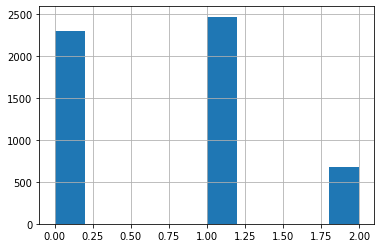

In [77]:
cur.loc[cur['labels'] == 0, 'sentiments'].hist()

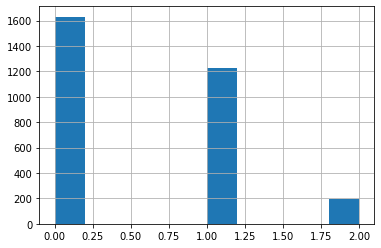

In [78]:
cur.loc[cur['labels'] == 1, 'sentiments'].hist()

In [81]:
texts, sentiments, labels = get_sentiment(val_dataset)

100%|██████████| 5/5 [00:20<00:00,  4.17s/it]


In [82]:
cur_val = pd.DataFrame(data={
    'texts': texts,
    'sentiments': sentiments, 
    'labels': labels,
})

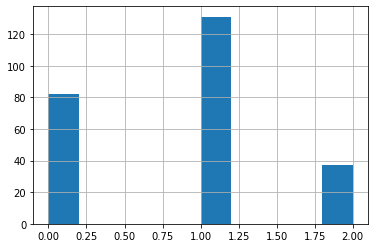

In [83]:
cur_val.loc[cur_val['labels'] == 0, 'sentiments'].hist()

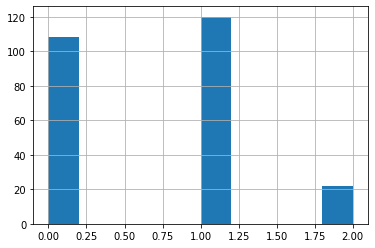

In [84]:
cur_val.loc[cur_val['labels'] == 1, 'sentiments'].hist()

**Here is an implementation of CLIP encoder for images and texts**

In [33]:
clip_image_embeder = ClipImageEmbeder(clip_model)
clip_text_embeder = ClipTextEmbeder(clip_model)

In [34]:
image_features_train, text_features_train, \
sa_features_train, labels_train = get_features(train_dataset, clip_image_embeder, clip_text_embeder, sa_text_embeder)
image_features_val, text_features_val,\
sa_features_val, labels_val = get_features(val_dataset, clip_image_embeder, clip_text_embeder, sa_text_embeder)

100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


In [35]:
features_train_dataset = FeaturesDataset(image_features_train, text_features_train, sa_features_train, labels_train)
features_val_dataset = FeaturesDataset(image_features_val, text_features_val, sa_features_val, labels_val)

In [36]:
for i_step, (x_image, x_text, x_sa, y) in enumerate(DataLoader(features_train_dataset, batch_size=500)):
  break

print(x_image.shape, x_text.shape, x_sa.shape)

image_input_dim = x_image.shape[1]
text_input_dim = x_text.shape[1]
sa_input_dim = x_sa.shape[1]

torch.Size([500, 768]) torch.Size([500, 768]) torch.Size([500, 3])


In [37]:
nn_model = ClipNNModel(image_input_dim, text_input_dim, sa_input_dim, hidden_layer_size=256, dropout=0.66, num_classes=2)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
print(nn_model)

ClipNNModel(
  (sa_linear): Linear(in_features=3, out_features=3, bias=True)
  (sa_activation): ReLU()
  (linear_1): Linear(in_features=1539, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.66, inplace=False)
  (batchnorm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.66, inplace=False)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_2): ReLU()
  (last_linear): Linear(in_features=256, out_features=2, bias=True)
)


In [38]:
loss_history, train_history, val_history, best_model_name = train_model(
    'clip_image_clip_text_sa_features_classifier',
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 300, scheduler)
print('end!')

Epoch: 0 lr: 0.010000; Average loss: 0.663626, Train accuracy: 0.661647, Val accuracy: 0.638000
saved clip_image_clip_text_sa_features_classifier_0_0.638.ckpt
Epoch: 1 lr: 0.010000; Average loss: 0.535619, Train accuracy: 0.731176, Val accuracy: 0.656000
saved clip_image_clip_text_sa_features_classifier_1_0.656.ckpt
Epoch: 2 lr: 0.010000; Average loss: 0.507270, Train accuracy: 0.748706, Val accuracy: 0.640000
Epoch: 3 lr: 0.010000; Average loss: 0.471601, Train accuracy: 0.769059, Val accuracy: 0.652000
Epoch: 4 lr: 0.010000; Average loss: 0.441985, Train accuracy: 0.789882, Val accuracy: 0.660000
saved clip_image_clip_text_sa_features_classifier_4_0.66.ckpt
Epoch: 5 lr: 0.010000; Average loss: 0.417747, Train accuracy: 0.802353, Val accuracy: 0.666000
saved clip_image_clip_text_sa_features_classifier_5_0.666.ckpt
Epoch: 6 lr: 0.010000; Average loss: 0.385144, Train accuracy: 0.820588, Val accuracy: 0.650000
Epoch: 7 lr: 0.010000; Average loss: 0.363054, Train accuracy: 0.834824, Val 

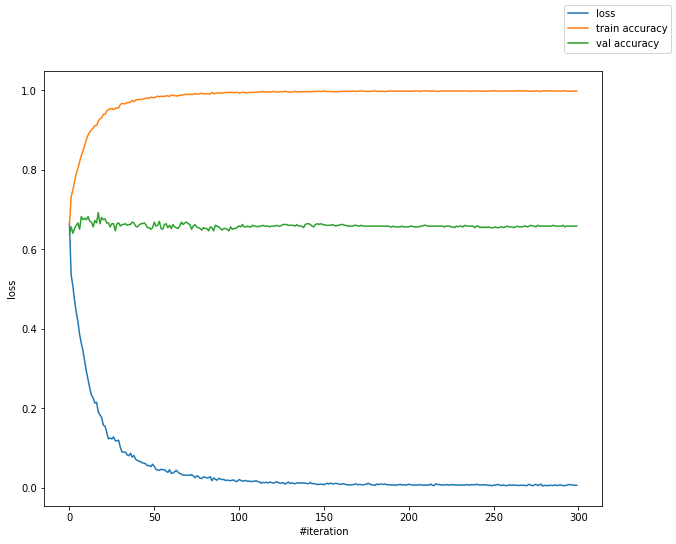

In [39]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, label='loss')
plt.plot(train_history, label='train accuracy')
plt.plot(val_history, label='val accuracy')
fig.legend()
plt.show()

In [40]:
print("best model:", best_model_name)

best model: clip_image_clip_text_sa_features_classifier_17_0.692.ckpt


In [41]:
best_model = torch.load(open(best_model_name, 'rb'))
print(best_model)

ClipNNModel(
  (sa_linear): Linear(in_features=3, out_features=3, bias=True)
  (sa_activation): ReLU()
  (linear_1): Linear(in_features=1539, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.66, inplace=False)
  (batchnorm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.66, inplace=False)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_2): ReLU()
  (last_linear): Linear(in_features=256, out_features=2, bias=True)
)


In [45]:
features_val_dataset[0]

(tensor([ 3.7427e-01, -2.4268e-01,  5.1270e-03, -1.3342e-01, -4.0820e-01,
         -1.6895e-01,  1.1719e+00,  3.3398e-01,  2.7783e-01, -1.7319e-02,
          6.4062e-01,  9.4666e-02, -2.8516e-01, -4.7266e-01,  4.3555e-01,
          6.8701e-01,  4.0845e-01,  7.7148e-01, -7.4316e-01,  2.2900e-01,
          6.5625e-01,  9.8096e-01,  1.7603e-01,  3.3325e-01, -6.2891e-01,
         -7.7197e-01, -2.3584e-01,  4.9072e-01,  5.3076e-01,  6.3086e-01,
         -7.5635e-01,  1.1816e-01,  1.0242e-01,  3.4766e-01,  6.5723e-01,
         -6.1328e-01, -3.5187e-02,  2.2034e-01, -5.2246e-02, -2.3315e-01,
          3.9160e-01, -2.1692e-01, -8.8562e-02,  2.6831e-01, -4.9268e-01,
         -6.9922e-01, -3.6865e-01, -3.3911e-01, -6.0400e-01,  3.2104e-01,
          1.6785e-01, -5.9717e-01,  7.3242e-01,  6.7920e-01, -5.1367e-01,
          2.7368e-01,  6.4307e-01, -1.2170e-01, -4.7998e-01, -9.7559e-01,
          8.9722e-02, -7.9639e-01, -1.4111e-01,  2.8979e-01,  5.4346e-01,
         -3.8281e-01, -8.5840e-01, -7.

In [47]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))

print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x_image, x_text, x_sa, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x_image, x_text, x_sa)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

best model: clip_image_clip_text_sa_features_classifier_17_0.692.ckpt
0.692
0.7551519999999999


0.7551519999999999


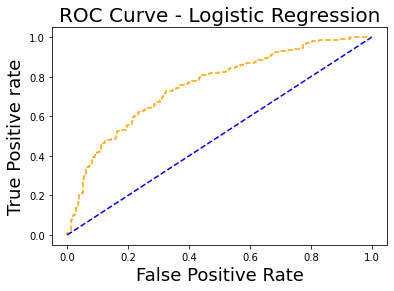

In [48]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

**Here is an implementation of CLIP encoder for images and HuggingFace BERT-Base encoder for texts**

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_base_text_embeder = BertTextEmbeder(bert_model, bert_tokenizer)

In [ ]:
image_features_train, text_features_train, labels_train = get_features(train_dataset, clip_image_embeder, 
                                                                       bert_base_text_embeder, sa_text_embeder)
image_features_val, text_features_val, labels_val = get_features(val_dataset, clip_image_embeder, 
                                                                 bert_base_text_embeder, sa_text_embeder)

100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


In [ ]:
features_train_dataset = FeaturesDataset(image_features_train, text_features_train, labels_train)
features_val_dataset = FeaturesDataset(image_features_val, text_features_val, labels_val)

for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_train_dataset, batch_size=500)):
  break

print(x_image.shape, x_text.shape)

image_input_dim = x_image.shape[1]
text_input_dim = x_text.shape[1]


nn_model = NNModel(image_input_dim, text_input_dim, hidden_layer_size=256, dropout=0.66, num_classes=2)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
print(nn_model)

torch.Size([500, 768]) torch.Size([500, 1536])
NNModel(
  (text_linear): Linear(in_features=1536, out_features=1536, bias=True)
  (text_activation): ReLU()
  (linear_1): Linear(in_features=2304, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.66, inplace=False)
  (batchnorm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.66, inplace=False)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_2): ReLU()
  (last_linear): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
loss_history, train_history, val_history, best_model_name = train_model(
    'clip_image_bert_base_text_classifier',
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 300, scheduler)
print('end!')


Epoch: 0 lr: 0.010000; Average loss: 0.738029, Train accuracy: 0.612824, Val accuracy: 0.532000
Epoch: 1 lr: 0.010000; Average loss: 0.624628, Train accuracy: 0.666588, Val accuracy: 0.560000
Epoch: 2 lr: 0.010000; Average loss: 0.600786, Train accuracy: 0.682000, Val accuracy: 0.590000
Epoch: 3 lr: 0.010000; Average loss: 0.584881, Train accuracy: 0.691294, Val accuracy: 0.570000
Epoch: 4 lr: 0.010000; Average loss: 0.573349, Train accuracy: 0.699294, Val accuracy: 0.552000
Epoch: 5 lr: 0.010000; Average loss: 0.562296, Train accuracy: 0.704118, Val accuracy: 0.570000
Epoch: 6 lr: 0.010000; Average loss: 0.555303, Train accuracy: 0.716353, Val accuracy: 0.570000
Epoch: 7 lr: 0.010000; Average loss: 0.538016, Train accuracy: 0.714118, Val accuracy: 0.544000
Epoch: 8 lr: 0.010000; Average loss: 0.526695, Train accuracy: 0.727765, Val accuracy: 0.532000
Epoch: 9 lr: 0.008000; Average loss: 0.511785, Train accuracy: 0.732588, Val accuracy: 0.554000
Epoch: 10 lr: 0.008000; Average loss: 0.

KeyboardInterrupt: ignored

In [ ]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, label='loss')
plt.plot(train_history, label='train accuracy')
plt.plot(val_history, label='val accuracy')
fig.legend()
plt.show()

In [ ]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))

print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x_image, x_text)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

In [ ]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

**Here is an implementation of CLIP encoder for images and HuggingFace BERT-Large encoder for texts**

In [ ]:
bert_large_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
bert_large_model = BertModel.from_pretrained("bert-large-uncased").to(device)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_large_text_embeder = BertTextEmbeder(bert_large_model, bert_large_tokenizer)

In [ ]:
image_features_train, text_features_train, labels_train = get_features(train_dataset, clip_image_embeder, bert_large_text_embeder)
image_features_val, text_features_val, labels_val = get_features(val_dataset, clip_image_embeder, bert_large_text_embeder)

100%|██████████| 5/5 [00:26<00:00,  5.20s/it]


In [ ]:
features_train_dataset = FeaturesDataset(image_features_train, text_features_train, labels_train)
features_val_dataset = FeaturesDataset(image_features_val, text_features_val, labels_val)

for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_train_dataset, batch_size=500)):
  break

print(x_image.shape, x_text.shape)

image_input_dim = x_image.shape[1]
text_input_dim = x_text.shape[1]


nn_model = NNModel(image_input_dim, text_input_dim, hidden_layer_size=256, dropout=0.66, num_classes=2)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
print(nn_model)

torch.Size([500, 768]) torch.Size([500, 1024])
NNModel(
  (text_linear): Linear(in_features=1024, out_features=1024, bias=True)
  (text_activation): ReLU()
  (linear_1): Linear(in_features=1792, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.66, inplace=False)
  (batchnorm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.66, inplace=False)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_2): ReLU()
  (last_linear): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
loss_history, train_history, val_history, best_model_name = train_model(
    'clip_image_bert_large_text_classifier',
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 300, scheduler)
print('end!')

Epoch: 0 lr: 0.010000; Average loss: 0.707832, Train accuracy: 0.624118, Val accuracy: 0.530000
Epoch: 1 lr: 0.010000; Average loss: 0.633132, Train accuracy: 0.650941, Val accuracy: 0.560000
Epoch: 2 lr: 0.010000; Average loss: 0.595747, Train accuracy: 0.687059, Val accuracy: 0.554000
Epoch: 3 lr: 0.010000; Average loss: 0.567660, Train accuracy: 0.706353, Val accuracy: 0.566000
Epoch: 4 lr: 0.010000; Average loss: 0.548541, Train accuracy: 0.724588, Val accuracy: 0.540000
Epoch: 5 lr: 0.010000; Average loss: 0.529421, Train accuracy: 0.733647, Val accuracy: 0.586000
Epoch: 6 lr: 0.010000; Average loss: 0.507180, Train accuracy: 0.749765, Val accuracy: 0.574000
Epoch: 7 lr: 0.010000; Average loss: 0.489178, Train accuracy: 0.755647, Val accuracy: 0.624000
saved clip_image_bert_large_text_classifier_7_0.624.ckpt
Epoch: 8 lr: 0.010000; Average loss: 0.474208, Train accuracy: 0.773412, Val accuracy: 0.610000
Epoch: 9 lr: 0.008000; Average loss: 0.456160, Train accuracy: 0.776588, Val ac

In [ ]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))

print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x_image, x_text)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

best model: clip_image_bert_large_text_classifier_7_0.624.ckpt
0.624
0.638416


0.638416


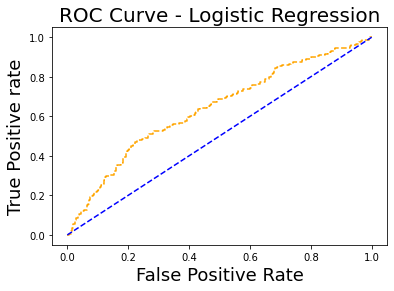

In [ ]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

**Here is an implementation of CLIP encoder for images and HuggingFace GPT2 encoder for texts**

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model

In [ ]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2Model.from_pretrained('gpt2').to(device)
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

In [ ]:
gpt2_text_embeder = GPT2TextEmbeder(gpt_model, gpt_tokenizer)

In [ ]:
image_features_train, text_features_train, labels_train = get_features(train_dataset, clip_image_embeder, gpt2_text_embeder)
image_features_val, text_features_val, labels_val = get_features(val_dataset, clip_image_embeder, gpt2_text_embeder)

100%|██████████| 5/5 [00:24<00:00,  4.86s/it]


In [ ]:
features_train_dataset = FeaturesDataset(image_features_train, text_features_train, labels_train)
features_val_dataset = FeaturesDataset(image_features_val, text_features_val, labels_val)

for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_train_dataset, batch_size=500)):
  break

print(x_image.shape, x_text.shape)

image_input_dim = x_image.shape[1]
text_input_dim = x_text.shape[1]


nn_model = NNModel(image_input_dim, text_input_dim, hidden_layer_size=256, dropout=0.66, num_classes=2)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
print(nn_model)

torch.Size([500, 768]) torch.Size([500, 768])
NNModel(
  (text_linear): Linear(in_features=768, out_features=768, bias=True)
  (text_activation): ReLU()
  (linear_1): Linear(in_features=1536, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.66, inplace=False)
  (batchnorm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.66, inplace=False)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_2): ReLU()
  (last_linear): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
loss_history, train_history, val_history, best_model_name = train_model(
    'clip_image_gpt2_text_classifier',
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 300, scheduler)
print('end!')

Epoch: 0 lr: 0.010000; Average loss: 0.723630, Train accuracy: 0.643882, Val accuracy: 0.498000
Epoch: 1 lr: 0.010000; Average loss: 0.633468, Train accuracy: 0.702118, Val accuracy: 0.500000
Epoch: 2 lr: 0.010000; Average loss: 0.596226, Train accuracy: 0.718235, Val accuracy: 0.526000
Epoch: 3 lr: 0.010000; Average loss: 0.583125, Train accuracy: 0.728000, Val accuracy: 0.502000
Epoch: 4 lr: 0.010000; Average loss: 0.553095, Train accuracy: 0.737412, Val accuracy: 0.632000
saved clip_image_gpt2_text_classifier_4_0.632.ckpt
Epoch: 5 lr: 0.010000; Average loss: 0.520078, Train accuracy: 0.748118, Val accuracy: 0.518000
Epoch: 6 lr: 0.010000; Average loss: 0.499610, Train accuracy: 0.758235, Val accuracy: 0.500000
Epoch: 7 lr: 0.010000; Average loss: 0.481395, Train accuracy: 0.766000, Val accuracy: 0.500000
Epoch: 8 lr: 0.010000; Average loss: 0.458920, Train accuracy: 0.779059, Val accuracy: 0.648000
saved clip_image_gpt2_text_classifier_8_0.648.ckpt
Epoch: 9 lr: 0.008000; Average los

In [ ]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))

print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x_image, x_text)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

best model: clip_image_gpt2_text_classifier_87_0.682.ckpt
0.682
0.733792


0.733792


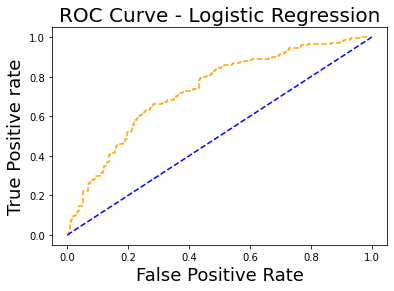

In [ ]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

**Here is an implementation of CLIP encoder for images and Fine-Tuned BERT-base encoder for texts**

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

bert_tuned_tokenizer = AutoTokenizer.from_pretrained("limjiayi/bert-hateful-memes-expanded")
bert_tuned_model = AutoModelForMaskedLM.from_pretrained("limjiayi/bert-hateful-memes-expanded", output_hidden_states=True).to(device)

Downloading:   0%|          | 0.00/321 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/664 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
bert_tuned_text_embeder = BertTunedTextEmbeder(bert_tuned_model, bert_tuned_tokenizer)

In [ ]:
image_features_train, text_features_train, labels_train = get_features(train_dataset, clip_image_embeder, bert_tuned_text_embeder)
image_features_val, text_features_val, labels_val = get_features(val_dataset, clip_image_embeder, bert_tuned_text_embeder)

100%|██████████| 5/5 [00:22<00:00,  4.47s/it]


In [ ]:
features_train_dataset = FeaturesDataset(image_features_train, text_features_train, labels_train)
features_val_dataset = FeaturesDataset(image_features_val, text_features_val, labels_val)

for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_train_dataset, batch_size=500)):
  break

print(x_image.shape, x_text.shape)

image_input_dim = x_image.shape[1]
text_input_dim = x_text.shape[1]


nn_model = NNModel(image_input_dim, text_input_dim, hidden_layer_size=256, dropout=0.66, num_classes=2)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
print(nn_model)

torch.Size([500, 768]) torch.Size([500, 768])
NNModel(
  (text_linear): Linear(in_features=768, out_features=768, bias=True)
  (text_activation): ReLU()
  (linear_1): Linear(in_features=1536, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.66, inplace=False)
  (batchnorm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.66, inplace=False)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_2): ReLU()
  (last_linear): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
loss_history, train_history, val_history, best_model_name = train_model(
    'clip_image_bert_tuned_text_classifier',
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 300, scheduler)
print('end!')

Epoch: 0 lr: 0.010000; Average loss: 0.715979, Train accuracy: 0.641294, Val accuracy: 0.592000
Epoch: 1 lr: 0.010000; Average loss: 0.564019, Train accuracy: 0.710471, Val accuracy: 0.644000
saved clip_image_bert_tuned_text_classifier_1_0.644.ckpt
Epoch: 2 lr: 0.010000; Average loss: 0.538612, Train accuracy: 0.730235, Val accuracy: 0.656000
saved clip_image_bert_tuned_text_classifier_2_0.656.ckpt
Epoch: 3 lr: 0.010000; Average loss: 0.518600, Train accuracy: 0.741059, Val accuracy: 0.658000
saved clip_image_bert_tuned_text_classifier_3_0.658.ckpt
Epoch: 4 lr: 0.010000; Average loss: 0.502636, Train accuracy: 0.756471, Val accuracy: 0.660000
saved clip_image_bert_tuned_text_classifier_4_0.66.ckpt
Epoch: 5 lr: 0.010000; Average loss: 0.489255, Train accuracy: 0.758471, Val accuracy: 0.564000
Epoch: 6 lr: 0.010000; Average loss: 0.466669, Train accuracy: 0.776588, Val accuracy: 0.642000
Epoch: 7 lr: 0.010000; Average loss: 0.458625, Train accuracy: 0.774588, Val accuracy: 0.574000
Epoch

In [ ]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))

print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x_image, x_text)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

best model: clip_image_bert_tuned_text_classifier_12_0.692.ckpt
0.692
0.744416


0.744416


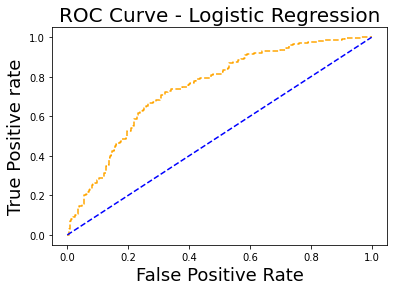

In [ ]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

**ROBERTa**

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base").to(device)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
roberta_text_embeder = BertTextEmbeder(roberta_model, roberta_tokenizer)

In [ ]:
image_features_train, text_features_train, labels_train = get_features(train_dataset, clip_image_embeder, roberta_text_embeder)
image_features_val, text_features_val, labels_val = get_features(val_dataset, clip_image_embeder, roberta_text_embeder)

100%|██████████| 5/5 [00:20<00:00,  4.12s/it]


In [ ]:
features_train_dataset = FeaturesDataset(image_features_train, text_features_train, labels_train)
features_val_dataset = FeaturesDataset(image_features_val, text_features_val, labels_val)

for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_train_dataset, batch_size=500)):
  break

print(x_image.shape, x_text.shape)

image_input_dim = x_image.shape[1]
text_input_dim = x_text.shape[1]


nn_model = NNModel(image_input_dim, text_input_dim, hidden_layer_size=256, dropout=0.66, num_classes=2)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
print(nn_model)

torch.Size([500, 768]) torch.Size([500, 768])
NNModel(
  (text_linear): Linear(in_features=768, out_features=768, bias=True)
  (text_activation): ReLU()
  (linear_1): Linear(in_features=1536, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.66, inplace=False)
  (batchnorm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.66, inplace=False)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_2): ReLU()
  (last_linear): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
loss_history, train_history, val_history, best_model_name = train_model(
    'clip_image_roberta_text_classifier',
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 300, scheduler)
print('end!')

Epoch: 0 lr: 0.010000; Average loss: 0.692338, Train accuracy: 0.659176, Val accuracy: 0.624000
saved clip_image_roberta_text_classifier_0_0.624.ckpt
Epoch: 1 lr: 0.010000; Average loss: 0.548420, Train accuracy: 0.726471, Val accuracy: 0.652000
saved clip_image_roberta_text_classifier_1_0.652.ckpt
Epoch: 2 lr: 0.010000; Average loss: 0.512785, Train accuracy: 0.743765, Val accuracy: 0.650000
Epoch: 3 lr: 0.010000; Average loss: 0.484038, Train accuracy: 0.760706, Val accuracy: 0.580000
Epoch: 4 lr: 0.010000; Average loss: 0.465169, Train accuracy: 0.772471, Val accuracy: 0.576000
Epoch: 5 lr: 0.010000; Average loss: 0.439143, Train accuracy: 0.787412, Val accuracy: 0.580000
Epoch: 6 lr: 0.010000; Average loss: 0.423581, Train accuracy: 0.796000, Val accuracy: 0.646000
Epoch: 7 lr: 0.010000; Average loss: 0.393561, Train accuracy: 0.818235, Val accuracy: 0.648000
Epoch: 8 lr: 0.010000; Average loss: 0.384266, Train accuracy: 0.821059, Val accuracy: 0.650000
Epoch: 9 lr: 0.008000; Avera

In [ ]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))

print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x_image, x_text)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

best model: clip_image_roberta_text_classifier_36_0.678.ckpt
0.678
0.7308159999999999


0.7308159999999999


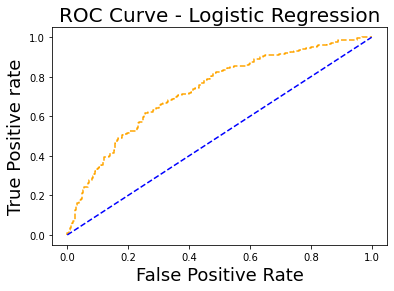

In [ ]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

**XLNET**

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import XLNetTokenizer, XLNetModel

xlnet_tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
xlnet_model = XLNetModel.from_pretrained("xlnet-base-cased").to(device)

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
xlnet_text_embeder = XLNetTextEmbeder(xlnet_model, xlnet_tokenizer)

In [ ]:
image_features_train, text_features_train, labels_train = get_features(train_dataset, clip_image_embeder, xlnet_text_embeder)
image_features_val, text_features_val, labels_val = get_features(val_dataset, clip_image_embeder, xlnet_text_embeder)

100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


In [ ]:
features_train_dataset = FeaturesDataset(image_features_train, text_features_train, labels_train)
features_val_dataset = FeaturesDataset(image_features_val, text_features_val, labels_val)

for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_train_dataset, batch_size=500)):
  break

print(x_image.shape, x_text.shape)

image_input_dim = x_image.shape[1]
text_input_dim = x_text.shape[1]


nn_model = NNModel(image_input_dim, text_input_dim, hidden_layer_size=256, dropout=0.66, num_classes=2)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
print(nn_model)

torch.Size([500, 768]) torch.Size([500, 768])
NNModel(
  (text_linear): Linear(in_features=768, out_features=768, bias=True)
  (text_activation): ReLU()
  (linear_1): Linear(in_features=1536, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.66, inplace=False)
  (batchnorm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.66, inplace=False)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_2): ReLU()
  (last_linear): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
loss_history, train_history, val_history, best_model_name = train_model(
    'clip_image_xlnet_text_classifier',
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 300, scheduler)
print('end!')

Epoch: 0 lr: 0.010000; Average loss: 0.757127, Train accuracy: 0.600353, Val accuracy: 0.526000
Epoch: 1 lr: 0.010000; Average loss: 0.660614, Train accuracy: 0.624588, Val accuracy: 0.538000
Epoch: 2 lr: 0.010000; Average loss: 0.639611, Train accuracy: 0.635882, Val accuracy: 0.522000
Epoch: 3 lr: 0.010000; Average loss: 0.620855, Train accuracy: 0.657294, Val accuracy: 0.522000
Epoch: 4 lr: 0.010000; Average loss: 0.609596, Train accuracy: 0.660471, Val accuracy: 0.542000
Epoch: 5 lr: 0.010000; Average loss: 0.598045, Train accuracy: 0.681059, Val accuracy: 0.522000
Epoch: 6 lr: 0.010000; Average loss: 0.585743, Train accuracy: 0.694235, Val accuracy: 0.514000
Epoch: 7 lr: 0.010000; Average loss: 0.575281, Train accuracy: 0.703765, Val accuracy: 0.524000
Epoch: 8 lr: 0.010000; Average loss: 0.558482, Train accuracy: 0.708235, Val accuracy: 0.604000
saved clip_image_xlnet_text_classifier_8_0.604.ckpt
Epoch: 9 lr: 0.008000; Average loss: 0.550758, Train accuracy: 0.713412, Val accurac

In [ ]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))

print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x_image, x_text)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

best model: clip_image_xlnet_text_classifier_45_0.616.ckpt
0.616
0.671696


0.671696


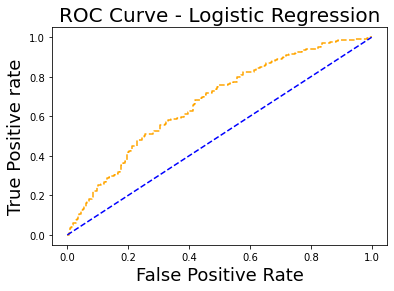

In [ ]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

**T5**

In [ ]:
from transformers import T5Tokenizer, T5EncoderModel

In [ ]:
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5EncoderModel.from_pretrained("t5-small").to(device)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of the model checkpoint at t5-small were not used when initializing T5EncoderModel: ['decoder.block.2.layer.1.layer_norm.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.2.layer.1.EncDecAttention.v.weight', 'decoder.block.2.layer.0.SelfAttention.k.weight', 'decoder.block.2.layer.2.layer_norm.weight', 'decoder.block.2.layer.0.SelfAttention.v.weight', 'decoder.block.3.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.v.weight', 'decoder.block.1.layer.0.layer_norm.weight', 'decoder.block.2.layer.0.layer_norm.weight', 'decoder.block.1.layer.1.EncDecAttention.o.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.3.layer.1.EncDecAttention.q.weight', 'decoder.block.3.layer.0.SelfAttention.q.weight', 'decoder.block.2.layer.1.EncDecAttention.o.weight', 'decoder.block.4.layer.0.SelfAttention.k.weight', 'decoder.block.4.layer.2.layer_norm.weight', 'decoder.block.2.layer.2.De

In [ ]:
t5_text_embeder = T5TextEmbeder(t5_model, t5_tokenizer)

In [ ]:
image_features_train, text_features_train, labels_train = get_features(train_dataset, clip_image_embeder, t5_text_embeder)
image_features_val, text_features_val, labels_val = get_features(val_dataset, clip_image_embeder, t5_text_embeder)

100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


In [ ]:
features_train_dataset = FeaturesDataset(image_features_train, text_features_train, labels_train)
features_val_dataset = FeaturesDataset(image_features_val, text_features_val, labels_val)

for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_train_dataset, batch_size=500)):
  break

print(x_image.shape, x_text.shape)

image_input_dim = x_image.shape[1]
text_input_dim = x_text.shape[1]


nn_model = NNModel(image_input_dim, text_input_dim, hidden_layer_size=256, dropout=0.66, num_classes=2)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
print(nn_model)

torch.Size([500, 768]) torch.Size([500, 512])
NNModel(
  (text_linear): Linear(in_features=512, out_features=512, bias=True)
  (text_activation): ReLU()
  (linear_1): Linear(in_features=1280, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.66, inplace=False)
  (batchnorm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.66, inplace=False)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_2): ReLU()
  (last_linear): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
loss_history, train_history, val_history, best_model_name = train_model(
    'clip_image_t5_text_classifier',
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 300, scheduler)
print('end!')

Epoch: 0 lr: 0.010000; Average loss: 0.665551, Train accuracy: 0.654235, Val accuracy: 0.618000
saved clip_image_t5_text_classifier_0_0.618.ckpt
Epoch: 1 lr: 0.010000; Average loss: 0.578658, Train accuracy: 0.705059, Val accuracy: 0.566000
Epoch: 2 lr: 0.010000; Average loss: 0.537834, Train accuracy: 0.730235, Val accuracy: 0.550000
Epoch: 3 lr: 0.010000; Average loss: 0.510591, Train accuracy: 0.740000, Val accuracy: 0.570000
Epoch: 4 lr: 0.010000; Average loss: 0.494038, Train accuracy: 0.755176, Val accuracy: 0.598000
Epoch: 5 lr: 0.010000; Average loss: 0.470388, Train accuracy: 0.766235, Val accuracy: 0.628000
saved clip_image_t5_text_classifier_5_0.628.ckpt
Epoch: 6 lr: 0.010000; Average loss: 0.454867, Train accuracy: 0.780235, Val accuracy: 0.586000
Epoch: 7 lr: 0.010000; Average loss: 0.435421, Train accuracy: 0.792353, Val accuracy: 0.628000
Epoch: 8 lr: 0.010000; Average loss: 0.424304, Train accuracy: 0.797412, Val accuracy: 0.566000
Epoch: 9 lr: 0.008000; Average loss: 0

In [ ]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))

print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x_image, x_text)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

best model: clip_image_t5_text_classifier_15_0.664.ckpt
0.664
0.735856


0.735856


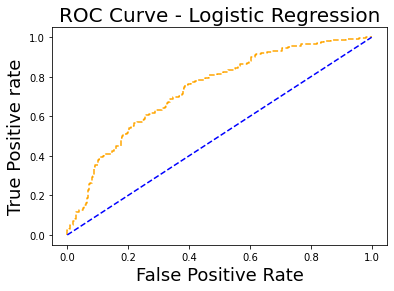

In [ ]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

**ELECTRA**

In [ ]:
from transformers import ElectraTokenizer, ElectraModel

In [ ]:
electra_tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")
electra_model = ElectraModel.from_pretrained("google/electra-small-discriminator").to(device)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
electra_text_embeder = ElectraTextEmbeder(electra_model, electra_tokenizer)

In [ ]:
image_features_train, text_features_train, labels_train = get_features(train_dataset, clip_image_embeder, electra_text_embeder)
image_features_val, text_features_val, labels_val = get_features(val_dataset, clip_image_embeder, electra_text_embeder)

100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


In [ ]:
features_train_dataset = FeaturesDataset(image_features_train, text_features_train, labels_train)
features_val_dataset = FeaturesDataset(image_features_val, text_features_val, labels_val)

for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_train_dataset, batch_size=500)):
  break

print(x_image.shape, x_text.shape)

image_input_dim = x_image.shape[1]
text_input_dim = x_text.shape[1]


nn_model = NNModel(image_input_dim, text_input_dim, hidden_layer_size=256, dropout=0.66, num_classes=2)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
print(nn_model)

torch.Size([500, 768]) torch.Size([500, 256])
NNModel(
  (text_linear): Linear(in_features=256, out_features=256, bias=True)
  (text_activation): ReLU()
  (linear_1): Linear(in_features=1024, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.66, inplace=False)
  (batchnorm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.66, inplace=False)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_2): ReLU()
  (last_linear): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
loss_history, train_history, val_history, best_model_name = train_model(
    'clip_image_electra_text_classifier',
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 300, scheduler)
print('end!')

Epoch: 0 lr: 0.010000; Average loss: 0.722855, Train accuracy: 0.632588, Val accuracy: 0.592000
Epoch: 1 lr: 0.010000; Average loss: 0.574375, Train accuracy: 0.708588, Val accuracy: 0.624000
saved clip_image_electra_text_classifier_1_0.624.ckpt
Epoch: 2 lr: 0.010000; Average loss: 0.548363, Train accuracy: 0.721765, Val accuracy: 0.648000
saved clip_image_electra_text_classifier_2_0.648.ckpt
Epoch: 3 lr: 0.010000; Average loss: 0.526380, Train accuracy: 0.735765, Val accuracy: 0.674000
saved clip_image_electra_text_classifier_3_0.674.ckpt
Epoch: 4 lr: 0.010000; Average loss: 0.504966, Train accuracy: 0.746824, Val accuracy: 0.598000
Epoch: 5 lr: 0.010000; Average loss: 0.495868, Train accuracy: 0.756235, Val accuracy: 0.624000
Epoch: 6 lr: 0.010000; Average loss: 0.479802, Train accuracy: 0.767647, Val accuracy: 0.658000
Epoch: 7 lr: 0.010000; Average loss: 0.469580, Train accuracy: 0.773294, Val accuracy: 0.676000
saved clip_image_electra_text_classifier_7_0.676.ckpt
Epoch: 8 lr: 0.0

In [ ]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))

print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x_image, x_text, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x_image, x_text)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

best model: clip_image_electra_text_classifier_23_0.684.ckpt
0.684
0.7380159999999999


0.7380159999999999


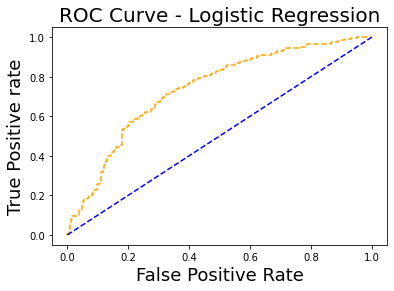

In [ ]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();